In [1]:
import boto3
import matplotlib.pyplot as plt
import cv2
import pandas as pd
import numpy as np
import os

In [2]:
s3 = boto3.resource('s3')

In [3]:
for bucket in s3.buckets.all():
    print(bucket)

s3.Bucket(name='celebrities-west-2')


In [4]:
bucket = 'celebrities-west-2'

In [5]:
client = boto3.client('rekognition', 'us-west-2')

### Functions

In [6]:
def img2rgb(image):
    return cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

In [7]:
def get_label_parents(categories):
    if len(categories) == 0:
        return categories
    return [category['Name'] for category in categories]

In [8]:
def draw_bounding_box(img, bounding_box, text=''):
    width = img.shape[1]
    height = img.shape[0]
    w, h = int(bounding_box[0]*width), int(bounding_box[1]*height)
    x, y = int(bounding_box[2]*width), int(bounding_box[3]*height)
    cv2.rectangle(img, (x, y), (x+w, y+h), (255, 255, 0), 3)
    cv2.putText(img, text, (x, y+20), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (255, 0, 0), 2, cv2.LINE_AA)
    return img

In [9]:
def convert_img_to_bytes(file):
    with open(file, 'rb') as f:
        source_bytes = f.read()
    return source_bytes

## Detect labels

In [10]:
sourceFile = 'jennette_mccurdy_3.jpeg'
boto3.client('s3').download_file(bucket, sourceFile, os.path.join('images', sourceFile))

In [11]:
detect_labels = client.detect_labels(Image={'S3Object': {'Bucket': bucket, 'Name': sourceFile}})

In [12]:
df = pd.DataFrame(detect_labels['Labels']).drop('Instances', axis=1)
df.Parents = df.Parents.apply(get_label_parents)
df

,Name,Confidence,Parents
0,Apparel,99.906143,[]
1,Clothing,99.906143,[]
2,Dress,99.104202,[Clothing]
3,Person,98.831276,[]
4,Human,98.831276,[]
5,Female,97.870201,[Person]
6,Woman,92.353996,"[Female, Person]"
7,Skirt,82.431580,[Clothing]
8,Footwear,73.997726,[Clothing]
9,Shoe,73.997726,"[Footwear, Clothing]"


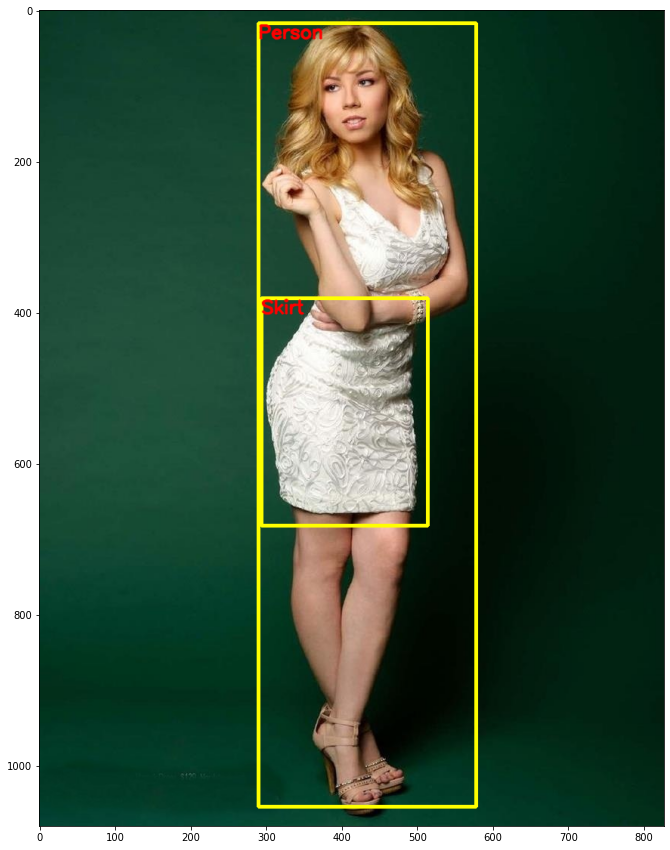

In [13]:
srcImg = img2rgb(cv2.imread(os.path.join('images', sourceFile)))

df_labels = pd.DataFrame(detect_labels['Labels'])
hasBoundingBox = df_labels['Instances'].str.len() == 1
df_labels = df_labels[['Name', 'Instances']].loc[hasBoundingBox]

for row in df_labels.itertuples():
    draw_bounding_box(srcImg, tuple(row.Instances[0]['BoundingBox'].values()), row.Name)

fig = plt.figure(figsize=(15, 15))
plt.imshow(srcImg)
plt.show()

## Compare faces

In [14]:
targetFile = 'jennette_mccurdy_4.jpeg'
boto3.client('s3').download_file(bucket, targetFile, os.path.join('images', targetFile))

In [15]:
compare_faces = client.compare_faces(SimilarityThreshold=70,
                               SourceImage={'S3Object': {'Bucket': bucket, 'Name': sourceFile}},
                               TargetImage={'S3Object': {'Bucket': bucket, 'Name': targetFile}})

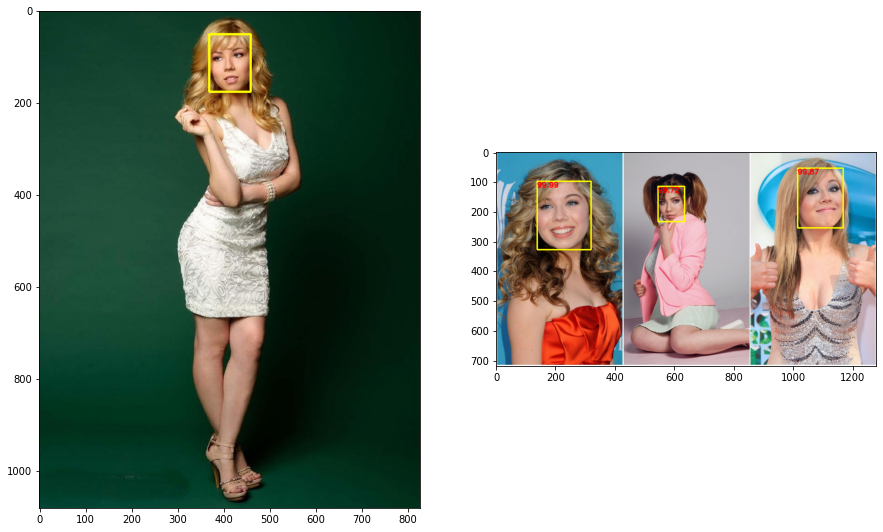

In [16]:
srcImg = img2rgb(cv2.imread(os.path.join('images', sourceFile)))
trgImg = img2rgb(cv2.imread(os.path.join('images', targetFile)))

draw_bounding_box(srcImg, tuple(compare_faces['SourceImageFace']['BoundingBox'].values()))

for face_match in compare_faces['FaceMatches']:
    similarity = str(round(face_match['Similarity'], 2))
    draw_bounding_box(trgImg, tuple(face_match['Face']['BoundingBox'].values()), similarity)
    
fig, axs = plt.subplots(1, 2, figsize=(15, 15))
axs[0].imshow(srcImg)
axs[1].imshow(trgImg)
plt.show()

## Recognize celebrities

In [17]:
sourceFile = 'elizabeth_olsen_3.jpeg'
boto3.client('s3').download_file(bucket, sourceFile, os.path.join('images', sourceFile))

In [18]:
recognize_celebrities = client.recognize_celebrities(Image={'Bytes': convert_img_to_bytes(os.path.join('images', sourceFile))})

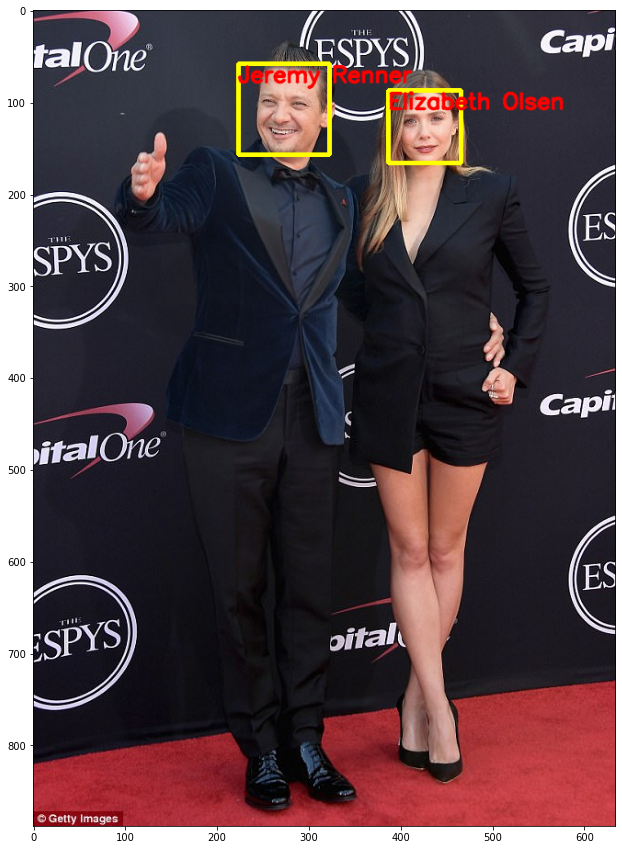

In [19]:
srcImg = img2rgb(cv2.imread(os.path.join('images', sourceFile)))

for celebrity in recognize_celebrities['CelebrityFaces']:
    name = celebrity['Name']
    draw_bounding_box(srcImg, tuple(celebrity['Face']['BoundingBox'].values()), name)
    
fig = plt.figure(figsize=(15, 15))
plt.imshow(srcImg)
plt.show()

## Face detection

In [20]:
sourceFile = 'stan_lee_3.jpeg'
boto3.client('s3').download_file(bucket, sourceFile, os.path.join('images', sourceFile))

In [21]:
detect_faces = client.detect_faces(Image={'Bytes': convert_img_to_bytes(os.path.join('images', sourceFile))}, Attributes=['ALL'])

0
Age range: 49 - 67
Smile: True
Eyeglasses: True
Sunglasses: True
Gender: Male
Beard: True
Mustache: False
EyesOpen: True
MouthOpen: True
Emotions: ['HAPPY', 'CALM', 'SURPRISED', 'DISGUSTED', 'CONFUSED', 'ANGRY', 'SAD', 'FEAR']
1
Age range: 27 - 43
Smile: True
Eyeglasses: False
Sunglasses: False
Gender: Male
Beard: True
Mustache: False
EyesOpen: True
MouthOpen: True
Emotions: ['HAPPY', 'CALM', 'SURPRISED', 'CONFUSED', 'ANGRY', 'FEAR', 'DISGUSTED', 'SAD']
2
Age range: 22 - 34
Smile: False
Eyeglasses: False
Sunglasses: False
Gender: Female
Beard: False
Mustache: False
EyesOpen: True
MouthOpen: False
Emotions: ['CALM', 'SAD', 'HAPPY', 'FEAR', 'ANGRY', 'CONFUSED', 'SURPRISED', 'DISGUSTED']


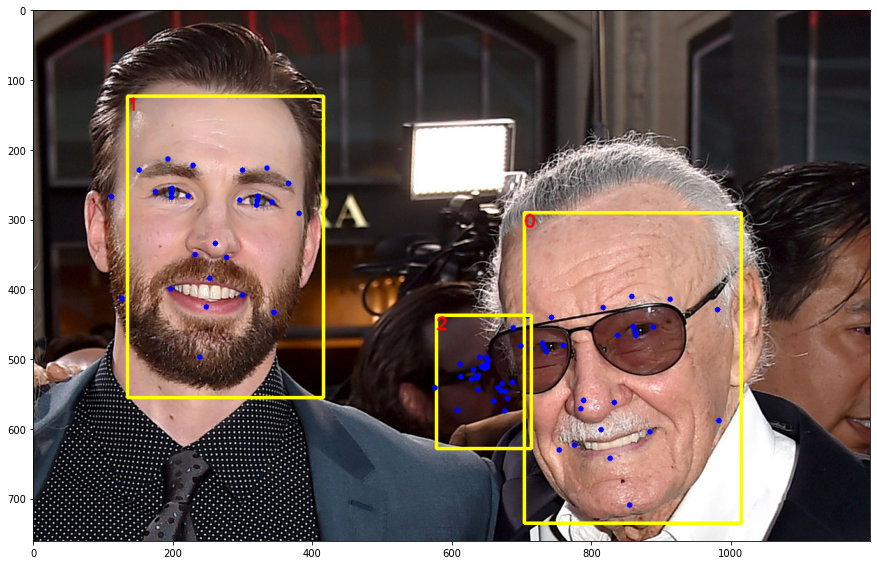

In [22]:
srcImg = img2rgb(cv2.imread(os.path.join('images', sourceFile)))

for index, face in enumerate(detect_faces['FaceDetails']):
    print(index)
    print('Age range: %d - %d' % (face['AgeRange']['Low'], face['AgeRange']['High']))
    print('Smile: %r' % face['Smile']['Value'])
    print('Eyeglasses: %r' % face['Eyeglasses']['Value'])
    print('Sunglasses: %r' % face['Sunglasses']['Value'])
    print('Gender: %s' % face['Gender']['Value'])
    print('Beard: %r' % face['Beard']['Value'])
    print('Mustache: %r' % face['Mustache']['Value'])
    print('EyesOpen: %r' % face['EyesOpen']['Value'])
    print('MouthOpen: %r' % face['MouthOpen']['Value'])
    print('Emotions: %s' % [emotion['Type'] for emotion in face['Emotions']])
    
    draw_bounding_box(srcImg, tuple(face['BoundingBox'].values()), str(index))
    
    for landmark in face['Landmarks']:
        x, y = int(landmark['X'] * srcImg.shape[1]), int(landmark['Y'] * srcImg.shape[0])
        cv2.circle(srcImg, (x, y), 4, (0, 0, 255), -1)
        
fig = plt.figure(figsize=(15, 15))
plt.imshow(srcImg)
plt.show()

## TODO

- beard color
- mustache color
- hair color
- hair type
- tshirt color
- jeans color
- hat
- skin color
- piercing
- tattoo